In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from google.colab import drive
drive.mount('/content/drive')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda
Tesla P100-PCIE-16GB


In [2]:
file_path = 'drive/MyDrive/distribution_system_state_est/test_data/ieee123/0802_Case2/'

x0=np.load(file_path + 'X.npy') # p_c,p_g,q_c
y0=np.load(file_path + 'Y.npy')
W0=np.load(file_path + 'w.npy')

# node index
filename = file_path + 'node_idx.txt'
node_idx = pd.read_table(filename,sep=',',header=None).to_numpy()
print('node index:',node_idx.shape)

# sensitivity matrices
filename = file_path + 'R.txt'
R_mat = pd.read_table(filename,sep=',',header=None).to_numpy()
filename = file_path + 'X.txt'
X_mat = pd.read_table(filename,sep=',',header=None).to_numpy()
print(' Sensitivity R:',R_mat.shape,'X:',X_mat.shape)



node index: (123, 1)
 Sensitivity R: (122, 122) X: (122, 122)


In [3]:
print(x0.shape,y0.shape)
print(y0[:,0])
# there are a few cases where no q_g input
for i in range(2):
  print(np.where(y0[:,i]>0.1))

(123, 3, 14400) (123, 14400)
[  0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        166.1435202  -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.        158.974878   -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        263.3530038  -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
 140.6152752  -0.         -0.         -0.      

189 [971, 972, 973, 976, 977, 980, 981, 982, 983, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1013, 1014, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1060, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1091, 1093, 1094, 1095, 1096, 1097, 1099, 1100, 1102, 1103, 1104, 1105, 1107, 1108, 1111, 1115, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1144, 1146, 1148, 1149, 1150, 1151, 3853, 3855, 3856, 3857, 3875, 4001, 4024, 4025, 4029, 4030, 4031, 4053, 4054, 5441, 5442, 5451, 5452, 5453, 5454, 5455, 5457, 5458, 5459, 5460, 5463, 5464, 5486, 5507, 6731, 6827, 6829, 6830, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6881, 6882, 6890

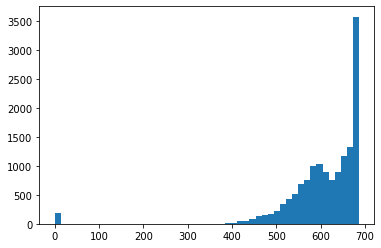

In [4]:
# nets can't handle when x is close but y=0 case, delete them
# err_strange_idx = [ 971,  972,  973,  997, 1042, 1043] in test set
yzero_list = []
n_sample = np.size(x0,2)
yzero_norm = np.zeros(n_sample)
for i in range(n_sample):
  yzero_norm[i] = np.linalg.norm(y0[:,i])
  if np.linalg.norm(y0[:,i])<1e-15:
    yzero_list.append(i)
print(len(yzero_list),yzero_list)
plt.hist(yzero_norm, bins = 50)
plt.show()

# yzero_list = []
# yzero_norm = np.zeros(int(n_sample*0.2))
# for i in range(int(n_sample*0.2)):
#   yzero_norm[i] = np.linalg.norm(y_test[:,i])
#   if yzero_norm[i]<1e-15:
#     yzero_list.append(i)
# print(len(yzero_list),yzero_list)
# print(yzero_norm)

# plt.hist(yzero_norm, bins = 50)
# plt.show()

0 []


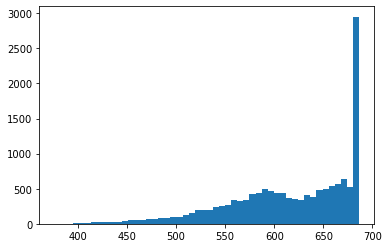

In [5]:
# Delete strange outliers
x0 = np.delete(x0,yzero_list,2)
y0 = np.delete(y0,yzero_list,1)
n_sample = np.size(x0,2)


yzero_list1 = []
yzero_norm = np.zeros(n_sample)
for i in range(n_sample):
  yzero_norm[i] = np.linalg.norm(y0[:,i])
  if np.linalg.norm(y0[:,i])<1e-15:
    yzero_list1.append(i)
print(len(yzero_list1),yzero_list1)
plt.hist(yzero_norm, bins = 50)
plt.show()

## Concatenate I/O to q_g only nodes
* Add additional info (global info)
* Current input: $p_c,p_g,q_c$
* Node 0 is the feeder head: x[0,0,0] = sum(x[1:,0,0])

In [6]:
qg_idx0 = np.where(y0[:,0]>0.1)
qg_idx = list(qg_idx0[0])
n_qg_idx = np.size(qg_idx) # number of nodes w/ reactive support
# print(y[qg_idx,0:2])

# # check input scale
# # may need to re-scale it later
# max_temp = 0
# for i in range(10000):
#    if np.sum(np.abs(x[:,1,i])) > max_temp:
#      max_temp = np.sum(x[:,1,i])
# print('p_g:',max_temp,'p_c:',np.max(x[1:,0,:]),'q_c:',np.max(x[1:,2,:]))

# generate new i/o
# x: p_c,p_g,q_c,p_c_sum,q_c_sum
x = np.zeros((n_qg_idx,3+2,np.size(x0,2)))
y = np.zeros((n_qg_idx,np.size(x0,2)))

for i in range(n_qg_idx):
  x[i,0:3,:] = x0[qg_idx[i],:,:].copy() # p_c,p_g,q_c
  x[i,3,:] = x0[0,0,:].copy() # p_c_sum
  x[i,4,:] = x0[0,2,:].copy() # q_c_sum
  y[i,:] = y0[qg_idx[i],:].copy()

W = np.identity(n_qg_idx) # graph filter

In [7]:
print(n_qg_idx,type(qg_idx),qg_idx)
print(x.shape)
for i in range(2):
  # print(n_qg_idx[0,i])
  # print(x[:,:,i])
  print(y[:,i])
# node_idx

6 <class 'list'> [32, 43, 56, 84, 114, 120]
(6, 5, 14211)
[166.1435202 158.974878  263.3530038 140.6152752 204.4540296 128.237316 ]
[158.637957  154.154316  246.133749  133.1719128 198.6641718 111.5053008]


In [8]:
# # W matrix (star communication network) - unweighted Laplacian
# n_node = np.size(node_idx) # full system
n_node = np.size(x,0)
n_sample = np.size(x,2)
print(n_node,n_sample)
# W = np.zeros((n_node,n_node))
# # W[0,0] = n_node - 1
# W[0,0] = 1 # disable communications to substation, only local info
# for i in range(n_node - 1):
#   # W[0,i+1] = -1
#   # W[i+1,0] = -1
#   W[i+1,i+1] = 1
# # print(np.sum(W,0))

# Normalization
W1 = W.copy()
# W1 = np.asarray(W1)
# # print(np.asarray([[2,3],[4,7]])/5)
# W1 = W1 / 1
# W2 = W1.copy()
# print(type(W))
# lam,v = np.linalg.eig(W1)
# print(lam[0])
# for i in range(5):
#   W1 = np.matmul(W1,W2) / np.max(np.matmul(W1,W2))
#   # print(W1)
#   lam,v = np.linalg.eig(W1)
#   print(lam[0])#/10**(i+1))

6 14211


## pre-processing of data

In [9]:
# # NN data:
# # Input: p_c,p_g,q_c

Sphase = 5.1834e+7 / 1000 # kw

# x = np.zeros((n_node,3,n_sample))
# x[1:,0,:] = p.copy() # p_c
# x[0,0,:] = np.sum(p,0)
# x[1:,1,:] = p_g.copy() # p_g
# x[1:,2,:] = q.copy() # q_c
# x[0,2,:] = np.sum(q,0)

# x[:,0,:] = x[:,0,:] * Sphase
# x[:,2,:] = x[:,2,:] * Sphase

# # Output: q_g
# y = np.zeros((n_node,n_sample))
# y[1:,:] = q_g.copy() * Sphase

print(x.shape,y.shape)

(6, 5, 14211) (6, 14211)


In [10]:
print(np.max(y),np.mean(y))
print(np.max(x[:,0,:]),np.mean(x[:,0,:]))
print(np.max(x[:,1,:]),np.mean(x[:,1,:]))
print(np.max(x[:,2,:]),np.mean(x[:,2,:]))

306.40114079999995 249.12671878695375
214.07442 41.19596284167541
136.17828479999997 21.453777396835374
95.6492802 25.660993726907748


In [11]:

print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))
from sklearn.model_selection import train_test_split

## randomly pick training and test
x_train,x_test,y_train,y_test = train_test_split(x.transpose(),y.transpose(),test_size=0.1, random_state=18)
x_train=x_train.transpose()
x_test=x_test.transpose()
y_train=y_train.transpose()
y_test=y_test.transpose()


## Pick first 8 days for training and last 2 for test
n_train1 = np.ceil(n_sample*0.8).astype(int)
x_train = x[:,:,0:n_train1].copy()
x_test = x[:,:,n_train1:].copy()
y_train = y[:,0:n_train1].copy()
y_test = y[:,n_train1:].copy()


print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, device='cpu'):
        self.features=torch.from_numpy(np.transpose(features)).float().to(device)
        self.labels=torch.from_numpy(np.transpose(labels)).float().to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = torch.reshape(X,(5,6)) # in-feature is 5, 6 nodes
        y = torch.reshape(y,(1,6))
        return X, y
params = {'batch_size': 200,
          'shuffle': True,
          'num_workers': 0}
# Dataset Generators
training_set = Dataset(features=x_train,labels=y_train,device=device)
training_generator = torch.utils.data.DataLoader(training_set,**params)
validation_set = Dataset(features=x_test,labels=y_test,device=device)
validation_generator = torch.utils.data.DataLoader(validation_set,**params)

(6, 5, 14211) (6, 14211)
8382.010829159999 -123.29235239999998 306.40114079999995 101.65684080000001
Training data size: (6, 5, 11369)
Training label size: (6, 11369)


# GNN model

In [12]:
from torch.autograd import Variable
# One layer Graph convolution from nodes to edges
class Graph_convolution_v2v_W(nn.Module):
    def __init__(self,in_features,out_features,W,n,bias=True):
        super(Graph_convolution_v2v_W,self).__init__()
        self.register_buffer('w',torch.from_numpy(W.transpose()).float())
        self.register_buffer('n0',torch.tensor(n))
        self.mapping=nn.Parameter(torch.Tensor(n,W.shape[0],W.shape[1]))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        self.scale0=nn.Parameter(torch.Tensor(out_features,in_features))
        torch.nn.init.xavier_uniform_(self.scale0.data)
        self.scale=nn.Parameter(torch.Tensor(n-1,out_features,out_features))
        torch.nn.init.xavier_uniform_(self.scale.data)
        self.bias=nn.Parameter(torch.Tensor(out_features,1))
        torch.nn.init.xavier_uniform_(self.bias.data)

    def forward(self,input):
        h=torch.mul(self.mapping[0,:,:],self.w)
        # print(h.shape,input.shape)
        h=torch.matmul(input,h) # transpose due to batch generator 
        # print(h.shape,self.scale0.shape)
        h=torch.matmul(self.scale0,h)
        for i in range(self.n0 - 1):
          W1 = torch.matrix_power(self.w,i+2)/torch.max(torch.matrix_power(self.w,i+2))
          h1=torch.mul(self.mapping[i,:,:],W1)
          h=torch.matmul(h,h1) # transpose due to batch generator 
          h=torch.matmul(self.scale[i,:,:],h)
        return h+self.bias 

# GNN using DGL v2v graph convolution and our own v2e graph convolution
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, W, num_bus, n_hop):
        super(GCN, self).__init__()
        self.conv_v2v1=Graph_convolution_v2v_W(in_feats,hidden_size[0],W,n_hop)
        self.conv_v2v2=Graph_convolution_v2v_W(hidden_size[0],hidden_size[1],W,n_hop)
        self.conv_v2v3=Graph_convolution_v2v_W(hidden_size[1],hidden_size[2],W,n_hop)
        self.conv_v2v4=Graph_convolution_v2v_W(hidden_size[2],hidden_size[3],W,n_hop)
        self.conv_v2v5=Graph_convolution_v2v_W(hidden_size[3],hidden_size[4],W,n_hop)
        self.conv_v2v6=Graph_convolution_v2v_W(hidden_size[4],hidden_size[5],W,n_hop)
        # self.conv_v2v7=Graph_convolution_v2v_W(hidden_size[5],hidden_size[6],W,n_hop)
        # self.conv_v2v8=Graph_convolution_v2v_W(hidden_size[6],hidden_size[7],W,n_hop)
        self.lin_output = nn.Linear(num_bus,num_bus)
         
    def forward(self, inputs):
        # m = nn.ELU()
        # m = nn.LeakyReLU()
        # m = nn.Tanh()
        m = nn.ReLU()
        h=self.conv_v2v1(inputs)
        h=m(h)
        h=self.conv_v2v2(h)
        h=m(h)
        h=self.conv_v2v3(h)
        h=m(h)
        h=self.conv_v2v4(h)
        h=m(h)
        h=self.conv_v2v5(h)
        h=m(h)
        h=self.conv_v2v6(h)
        # h=m(h)
        # h=torch.relu(h)
        # h = self.lin_output(h)
        # time.sleep(5)
        return h
n_bus=x.shape[0]
# w_params=[10,15,10,1]
w_params=[10,15,15,10,10,1]
n_hop = 2 # star shape
# W = W / 10 # normalize
net=GCN(5,w_params,W,n_bus, n_hop) # Laplacian
net=net.to(device)

# set loss_func & optimizer
loss_func=nn.MSELoss()
def my_loss_func(pred,label,W1):
  mse=loss_func(pred,label)
  lmda1=torch.from_numpy(np.array([1])).to(device) # L_2
  lmda2=torch.from_numpy(np.array([0.1])).to(device) # L_inf
  # lmda3=torch.from_numpy(np.array([0.02])).to(device) # locality
  linf=(pred-label).norm(p=float('inf'))
  # locality = torch.matmul(torch.matmul(pred,W1),pred.transpose(1,2))
  # print(pred.shape,pred.transpose(1,2).shape)
  return lmda1*mse + lmda2*linf #+ lmda3*torch.mean(locality) # mean/sum over batch
  # return mse
optimizer=torch.optim.Adam(net.parameters(),weight_decay=0.001)
loss_optm=[]
loss_val=[]
print(net)
# n_params = 0
# n_params_trainable = 0
# for temp in net.parameters():
#     # print(temp.shape[0])
#     # print(temp.shape)
#     n_params += temp.shape[0] * temp.shape[1]
#     if abs(temp.shape[0] - n_bus) > 0:
#       n_params_trainable += temp.shape[0] * temp.shape[1]
#     else:
#       n_params_trainable += n_bus + 2 * n_line
# print('Number of GNN parameters:',n_params)
# print('Number of effective GNN parameters:',n_params_trainable)

GCN(
  (conv_v2v1): Graph_convolution_v2v_W()
  (conv_v2v2): Graph_convolution_v2v_W()
  (conv_v2v3): Graph_convolution_v2v_W()
  (conv_v2v4): Graph_convolution_v2v_W()
  (conv_v2v5): Graph_convolution_v2v_W()
  (conv_v2v6): Graph_convolution_v2v_W()
  (lin_output): Linear(in_features=6, out_features=6, bias=True)
)


In [13]:
print(n_bus,W.shape)

6 (6, 6)


In [14]:
max_epochs=200
eval_epoch=5

t0 = time.time()

# earlystopping
tolerance= 5
min_delta=1e-4
previous=0

W_tensor = torch.from_numpy(W).float().to(device)
for epoch in range(max_epochs):
  t10 = time.time()
  # training loop
  train_loss=0.0
  for local_batch,local_label in training_generator:
    optimizer.zero_grad() # clear the past gradient
    # print(local_batch.shape)
    # print(local_batch)
    # print(local_label.shape)
    logits=net(local_batch)
    # print(logits.shape)
    loss=my_loss_func(logits,local_label,W_tensor)
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  t1 = time.time()
  loss_optm.append(train_loss/len(training_generator.dataset))
  print("Epoch %d | Time %.2fs | Training loss: %.4f"%(epoch,t1-t10,train_loss/len(training_generator.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for eval_batch,eval_label in validation_generator:
      eval_batch,eval_label=eval_batch.to(device),eval_label.to(device)
      logits=net(eval_batch)
      loss=loss_func(logits,eval_label)
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(validation_generator.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0: break
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch, eval_loss/len(validation_generator.dataset)])
    net.train()
  # validation loop
  with torch.set_grad_enabled(False):
      pass
t2 = time.time()
print("Training time:%.2fs"%(t2-t0))

Epoch 0 | Time 0.55s | Training loss: 317.6147
Epoch 1 | Time 0.52s | Training loss: 317.4075
Epoch 2 | Time 0.52s | Training loss: 316.7321
Epoch 3 | Time 0.52s | Training loss: 178.3621
Epoch 4 | Time 0.53s | Training loss: 13.4623
Epoch 4 | Eval loss: 11.2694
Epoch 5 | Time 0.51s | Training loss: 10.6208
Epoch 6 | Time 0.51s | Training loss: 10.5679
Epoch 7 | Time 0.53s | Training loss: 10.5116
Epoch 8 | Time 0.53s | Training loss: 10.4291
Epoch 9 | Time 0.52s | Training loss: 10.3736
Epoch 9 | Eval loss: 10.7477
Epoch 10 | Time 0.52s | Training loss: 10.2268
Epoch 11 | Time 0.52s | Training loss: 10.0994
Epoch 12 | Time 0.53s | Training loss: 9.9449
Epoch 13 | Time 0.52s | Training loss: 9.8146
Epoch 14 | Time 0.52s | Training loss: 9.6113
Epoch 14 | Eval loss: 10.0134
Epoch 15 | Time 0.51s | Training loss: 9.4049
Epoch 16 | Time 0.53s | Training loss: 9.1443
Epoch 17 | Time 0.51s | Training loss: 8.9042
Epoch 18 | Time 0.51s | Training loss: 8.4759
Epoch 19 | Time 0.51s | Training

In [15]:
print(len(loss_val))
print(loss_val[0][0])
# print(val_plt)
print(logits.shape,eval_label.shape)

16
4
torch.Size([42, 1, 6]) torch.Size([42, 1, 6])


16


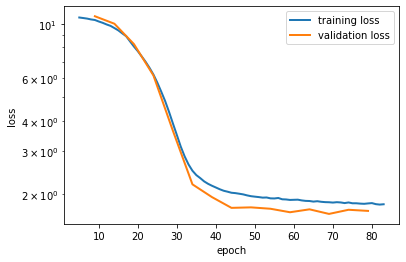

In [16]:
import matplotlib.pyplot as plt

val_len = len(loss_val)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = loss_val[i][0]
  val_plt[1,i] = loss_val[i][1]

plt.figure()
plot_idx = np.arange(np.size(loss_optm))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

In [17]:
# 
print(file_path)
np.save(file_path + 'results/mse_traing_idx.npy',arr=plot_idx)
np.save(file_path + 'results/mse_traing_loss.npy',arr=loss_optm)

drive/MyDrive/distribution_system_state_est/test_data/ieee123/0802_Case2/


# Evaluate the model w/ validation set

In [18]:
# local_batch, local_labels = local_batch.to(device), local_labels.to(device)
# print(local_batch.shape)
# x_test_feed = x_test_feed.unsqueeze_(-1).transpose(1,2)
# print(x_test_feed.shape)
print(local_batch.shape)

torch.Size([169, 5, 6])


In [19]:
# validation_set = Dataset(features=x_test, labels=y_test)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)
# for local_batch, local_labels in validation_generator:
#   # Transfer to GPU
#   local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#   logits = net(local_batch)

# x_train,x_test,y_train,y_test
# n_test = 2000
n_test = np.size(x_test,2)

x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = x_test_feed#.transpose(1,2)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
y_pred = net(x_test_feed)

Validation dataset size: torch.Size([2842, 5, 6])
Number of validation set:  2842


* Visualization




 - Visualize errors

In [20]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
print(y_test.shape)

(6, 2842)


In [21]:
print(y_test.shape,y_pred1.shape)

(6, 2842) (6, 2842)


In [22]:
# for i in range(5):
#   print('sample',i)
#   print(y_test[:,i])
#   print(y_pred1[:,i])

In [23]:
n_test = np.size(y_test,1)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test[:,i] - y_pred1[:,i]) / np.linalg.norm(y_test[:,i])
  err_Linf[i] = np.max(np.abs(y_test[:,i] - y_pred1[:,i])) / np.max(np.abs(y_test[:,i]))

err_full = np.zeros((n_node,n_test))
err_full = y_test - y_pred1

In [24]:
print(err_L2.shape,err_Linf.shape)

(2842,) (2842,)


L2 mean: 0.06626586283347194 L_inf mean: 0.09382615801632734


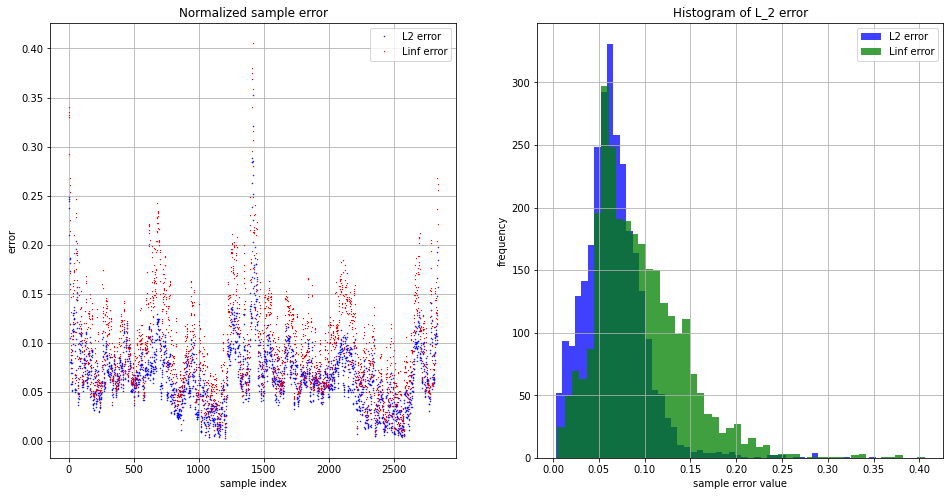

In [25]:
err_L2_mean = np.mean(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [26]:
# file_path
# np.save(file_path + 'results/qg_err_l2_local.npy',arr=err_L2)
# np.save(file_path + 'results/qg_err_test_mse.npy',arr=err_full)
# np.save('/content/drive/MyDrive/distribution_system_state_est/test_data/0225/Case_2/results/qg_err_linf_local.npy',arr=err_Linf)
# np.save('/content/drive/MyDrive/distribution_system_state_est/test_data/0225/Case_2/results/qg_err_full_local.npy',arr=err_full)

<function matplotlib.pyplot.show>

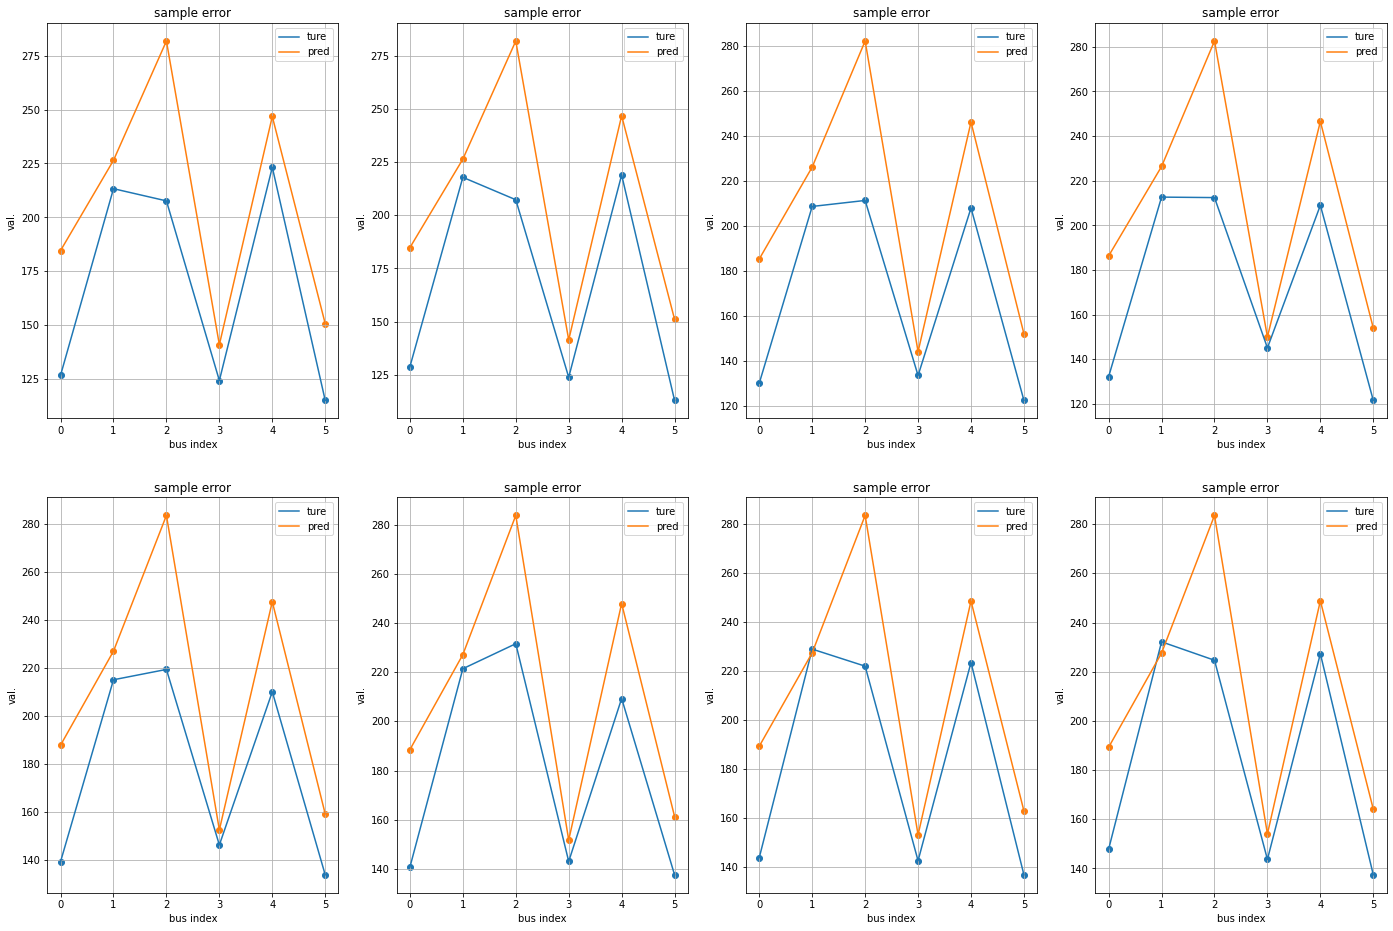

In [27]:
# print(y_test[:,0])
# print(y_pred1[:,0])
fig1 = plt.figure(figsize=(24, 16))
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.plot(y_test[:,i],label = 'ture')
  plt.scatter(np.arange(6),y_test[:,i])
  plt.plot(y_pred1[:,i],label = 'pred')
  plt.scatter(np.arange(6),y_pred1[:,i])
  # print(y_test[:,i])
  # print(y_pred1[:,i])
  plt.legend(loc="upper right")
  plt.xlabel('bus index')
  plt.ylabel('val.')
  plt.title('sample error')
  plt.grid(True)
plt.show

# Save the results

In [28]:
# net
# drive/MyDrive/distribution_system_state_est/test_data/0225/Case_1/
path='/content/drive/MyDrive/distribution_system_state_est/test_data/0225/Case_2/results/trained_net_local.pickle'
# torch.save(net.state_dict(),path)

In [29]:
# data
x_all = torch.from_numpy(np.transpose(x)).float()
x_all = x_all.to(device)

y_pred_all = net(x_all) # data is y
print(y_pred_all.shape,y.shape)

torch.Size([14211, 1, 6]) (6, 14211)


In [30]:
y_pred_all = y_pred_all.cpu().detach()
y_pred_all = torch.squeeze(y_pred_all,1).numpy().transpose()
print(y_pred_all.shape,y.shape)

(6, 14211) (6, 14211)


In [31]:
err_full = y - y_pred_all
# q_g error
np.save(file_path + 'results/qg_err_mse.npy',arr=err_full)

# Check (safe) feasibility

In [32]:
file_path1 = 'drive/MyDrive/distribution_system_state_est/test_data/0225/Case_gridlab/'

filename = file_path1 + 'gnn_voltage_abs_pu.txt'
v_abs_gnn = pd.read_table(filename,sep=',',header=None).to_numpy()
print('V GNN:',v_abs_gnn.shape)

V GNN: (110, 1440)


In [33]:
qg_pred_gnn = y_pred_all / Sphase # to pu

# p and q
# x[1:,0,:] = p.copy() # p_c
# x[1:,1,:] = p_g.copy() # p_g
# x[1:,2,:] = q.copy() # q_c
# p = x[1:,0,:].copy()
# q = x[1:,2,:].copy()
p = x0[1:,0,:].copy() / Sphase # <-------- Edits by Shanny
q = x0[1:,2,:].copy() / Sphase

# qg_idx is the index in full system
qg_pred_full = np.zeros((122,n_sample))
print(qg_pred_full.shape)
qg_pred_full[np.asarray(qg_idx)-1,:] = qg_pred_gnn.copy()

(122, 14211)


In [34]:
# print(np.max(qg_pred_gnn[:,0]))
# print(R_mat.shape,p.shape,X_mat.shape,qg_pred_gnn.shape) # ,q_g.shape,v_abs_1.shape
# print(qg_pred_gnn[:,1])
# print(q[:,1])
# print(p[:,1])
print(p.shape,q.shape)

(122, 14211) (122, 14211)


In [35]:
# v_gnn = np.matmul(R_mat,-p) + np.matmul(X_mat,qg_pred_gnn[1:,:] - q) # lin model
v_gnn = np.matmul(R_mat,-p) + np.matmul(X_mat,qg_pred_full - q) # lin model
dv_abs_gnn = (v_abs_gnn - 1) # simulation
print(np.max(np.abs(v_gnn)),np.max(np.abs(dv_abs_gnn)),np.min(v_gnn))

0.0493018571681093 0.04522000000000004 -0.0493018571681093


1440 110
-0.02005299186637504 -0.0493018571681093


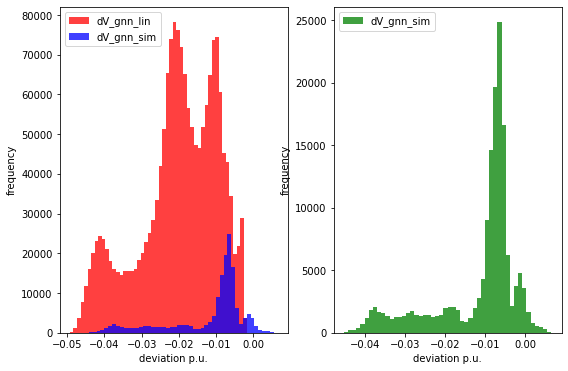

In [36]:
# v_true1 = np.reshape(v_true,(n_node-1)*n_sample)
n_sample1 = np.size(v_abs_gnn,1)
n_node1 = np.size(dv_abs_gnn,0)
print(n_sample1,n_node1)

v_gnn1 = np.reshape(v_gnn,(123-1)*n_sample)
v_gnn2 = np.reshape(dv_abs_gnn,(n_node1)*n_sample1)

# v_true2 = np.reshape(v_true_1,(n_node-1)*n_sample) # Gridlab
# v_true2 = np.reshape(dv_abs_1,(n_node-1)*n_sample) # Gridlab
# v_true3 = np.reshape(v_true_2,(n_node-1)*n_sample) # Linear model

print(np.mean(v_gnn1),np.min(v_gnn1))

fig1 = plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.hist(v_gnn1, bins = 50, facecolor='r', alpha=0.75,label = 'dV_gnn_lin')
plt.hist(v_gnn2, bins = 50, facecolor='b', alpha=0.75,label = 'dV_gnn_sim')
plt.legend(loc="upper left")
plt.xlabel('deviation p.u.')
plt.ylabel('frequency')
plt.subplot(1,2,2)
plt.hist(v_gnn2, bins = 50, facecolor='g', alpha=0.75,label = 'dV_gnn_sim')
plt.legend(loc="upper left")
plt.xlabel('deviation p.u.') 
plt.ylabel('frequency')
# plt.title('Histogram of Voltage Deviation')
plt.show()

In [37]:
# net
# file_path = 'drive/MyDrive/distribution_system_state_est/test_data/0506txt/'
# file_path = 'drive/MyDrive/distribution_system_state_est/test_data/ieee123/ieee123_w_q/'
path1= file_path + 'results/trained_net_regular_mse.pickle'
# torch.save(net.state_dict(),path1)
# q_g
print(y_pred_all.shape,y.shape)
np.save(file_path + 'results/qg_pred_regular_mse.npy',arr=y_pred_all)
# dv
# np.save(file_path + 'results/dv_pred_regular_mse.npy',arr=v_gnn1)

(6, 14211) (6, 14211)


In [38]:
# q_g true
# np.save(file_path + 'results/qg_true.npy',arr=y)